In [12]:
# %%
# =============================================================================
# 1. IMPORTS AND CONFIGURATION
# =============================================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from timm import create_model
import os
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import seaborn as sns
import json

warnings.filterwarnings('ignore')

# Configuration pointing to the timm model ID
config = {
    'base_dir': r'dataset/',
    'model_name': 'cait_s24_224',  # CHANGED: Removed the '.in1k' suffix
    'batch_size': 16,
    'img_size': 224,
    'weight_decay': 0.01,
    'epochs': 80,
    'num_workers': 0,
    'pin_memory': True,
    'patience': 12,
    'drop_rate': 0.4,
    'head_lr': 1e-3,
    'head_epochs': 10,
    'full_train_lr': 5e-5,
    'lr_warmup_epochs': 5,
    'label_smoothing': 0.1,
    'mixup_alpha': 0.4,
    'finetune_lr' : 1e-5,
    'finetune_epochs': 10

}

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [6]:
# =============================================================================
# 2. DATASET CLASS (No Changes Needed)
# =============================================================================
class MelSpectrogramDataset(Dataset):
    def __init__(self, base_dir, split='train', transform=None):
        self.split = split
        self.transform = transform
        self.data_dir = os.path.join(base_dir, split)
        self.classes = sorted([d for d in os.listdir(self.data_dir)
                               if os.path.isdir(os.path.join(self.data_dir, d))])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.image_paths = []
        self.labels = []

        for class_name in self.classes:
            class_dir = os.path.join(self.data_dir, class_name)
            for img_file in os.listdir(class_dir):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(class_dir, img_file))
                    self.labels.append(self.class_to_idx[class_name])

        print(f"Found {len(self.image_paths)} images in {split} set")
        print(f"Classes: {self.classes}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# =============================================================================
# 3. TRANSFORMS AND DATALOADERS
# =============================================================================
def get_enhanced_transforms(img_size):
    # CHANGED: Use standard ImageNet normalization for timm models
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    
    print(f"Using standard ImageNet normalization: mean={mean}, std={std}")

    train_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    val_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    return train_transform, val_transform

train_transform, val_transform = get_enhanced_transforms(config['img_size'])
train_dataset = MelSpectrogramDataset(config['base_dir'], 'train', train_transform)
val_dataset = MelSpectrogramDataset(config['base_dir'], 'val', val_transform)

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=config['num_workers'], pin_memory=config['pin_memory'])
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=config['num_workers'], pin_memory=config['pin_memory'])

num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")

# =============================================================================
# 4. AUGMENTATION (No Changes Needed)
# =============================================================================
class SpecAugment(nn.Module):
    def __init__(self, freq_mask_param, time_mask_param, num_freq_masks=1, num_time_masks=1):
        super(SpecAugment, self).__init__()
        self.F, self.T = freq_mask_param, time_mask_param
        self.num_freq_masks, self.num_time_masks = num_freq_masks, num_time_masks

    def forward(self, x):
        sh = x.shape
        for _ in range(self.num_freq_masks):
            f = np.random.uniform(0.0, self.F)
            f0 = np.random.randint(0, sh[2] - int(f)) if sh[2] > int(f) else 0
            x[:, :, f0:f0+int(f), :] = 0
        for _ in range(self.num_time_masks):
            t = np.random.uniform(0.0, self.T)
            t0 = np.random.randint(0, sh[3] - int(t)) if sh[3] > int(t) else 0
            x[:, :, :, t0:t0+int(t)] = 0
        return x

spec_augment = SpecAugment(freq_mask_param=25, time_mask_param=40).to(device)

def mixup_data(x, y, alpha=1.0):
    lam = np.random.beta(alpha, alpha) if alpha > 0 else 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# =============================================================================
# 5. MODEL DEFINITION (Using timm)
# =============================================================================
# CHANGED: Replaced TransformersClassifier with TimmClassifier
class TimmClassifier(nn.Module):
    def __init__(self, model_name, num_classes, drop_rate=0.3):
        super().__init__()
        # Load the backbone using create_model from the timm library
        self.backbone = create_model(
            model_name,
            pretrained=True,
            num_classes=0  # Set to 0 to remove the final classifier
        )
        
        # Get the feature dimension from the model
        feature_dim = self.backbone.num_features
        print(f"Feature dimension from timm model: {feature_dim}")

        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(drop_rate),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # The timm model directly outputs features after pooling
        features = self.backbone(x)
        return self.classifier(features)

model = TimmClassifier(
    config['model_name'], num_classes, config['drop_rate']
).to(device)
print("✅ Model created successfully using the timm library!")

# =============================================================================
# 6. TRAINING & VALIDATION LOOPS (No Changes Needed)
# =============================================================================
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss, all_preds, all_labels = 0.0, [], []
    pbar = tqdm(dataloader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        images = spec_augment(images)
        images, targets_a, targets_b, lam = mixup_data(images, labels, config['mixup_alpha'])
        optimizer.zero_grad()
        outputs = model(images)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
    return running_loss / len(dataloader), accuracy_score(all_labels, all_preds)

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss, all_preds, all_labels = 0.0, [], []
    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
    return running_loss / len(dataloader), accuracy_score(all_labels, all_preds), all_preds, all_labels

Using standard ImageNet normalization: mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
Found 19880 images in train set
Classes: ['Alapadmam(1)', 'Anjali(1)', 'Aralam(1)', 'Ardhachandran(1)', 'Ardhapathaka(1)', 'Berunda(1)', 'Bramaram(1)', 'Chakra(1)', 'Chandrakala(1)', 'Chaturam(1)', 'Garuda(1)', 'Hamsapaksha(1)', 'Hamsasyam(1)', 'Kangulam(1)', 'Kapith(1)', 'Kapotham(1)', 'Karkatta(1)', 'Kartariswastika(1)', 'Katakamukha_1', 'Katakamukha_2', 'Katakamukha_3', 'Katakavardhana(1)', 'Katrimukha(1)', 'Khatva(1)', 'Kilaka(1)', 'Kurma(1)', 'Matsya(1)', 'Mayura(1)', 'Mrigasirsha(1)', 'Mukulam(1)', 'Mushti(1)', 'Nagabandha(1)', 'Padmakosha(1)', 'Pasha(1)', 'Pathaka(1)', 'Pushpaputa(1)', 'Sakata(1)', 'Samputa(1)', 'Sarpasirsha(1)', 'Shanka(1)', 'Shivalinga(1)', 'Shukatundam(1)', 'Sikharam(1)', 'Simhamukham(1)', 'Suchi(1)', 'Swastikam(1)', 'Tamarachudam(1)', 'Tripathaka(1)', 'Trishulam(1)', 'Varaha(1)']
Found 4240 images in val set
Classes: ['Alapadmam(1)', 'Anjali(1)', 'Aralam(1)', 'Ardhac

In [7]:
# =============================================================================
# 7. PHASE 1: HEAD TRAINING
# =============================================================================
print("\n=== PHASE 1: Training only the classification head ===")
for param in model.backbone.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss(label_smoothing=config['label_smoothing'])
optimizer = optim.AdamW(model.classifier.parameters(), lr=config['head_lr'], weight_decay=config['weight_decay'])
best_head_acc = 0

for epoch in range(config['head_epochs']):
    print(f"\nEpoch {epoch+1}/{config['head_epochs']}")
    original_mixup_alpha = config['mixup_alpha']
    config['mixup_alpha'] = 0.0
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, _, _ = validate_epoch(model, val_loader, criterion, device)
    config['mixup_alpha'] = original_mixup_alpha
    print(f"Head Training - Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
    if val_acc > best_head_acc:
        best_head_acc = val_acc
        torch.save(model.state_dict(), 'best_head_model.pth')
        print(f"✅ New best head model saved! Accuracy: {val_acc:.4f}")

print(f"\n🎯 Phase 1 completed! Best head accuracy: {best_head_acc:.4f}")
model.load_state_dict(torch.load('best_head_model.pth'))




=== PHASE 1: Training only the classification head ===

Epoch 1/10


Validation: 100%|██████████| 265/265 [01:16<00:00,  3.44it/s, Loss=1.5706]


Head Training - Train Loss: 1.7800, Acc: 0.6580 | Val Loss: 1.2810, Acc: 0.8403
✅ New best head model saved! Accuracy: 0.8403

Epoch 2/10


Validation: 100%|██████████| 265/265 [00:50<00:00,  5.21it/s, Loss=0.8825]


Head Training - Train Loss: 1.4485, Acc: 0.7708 | Val Loss: 1.1984, Acc: 0.8748
✅ New best head model saved! Accuracy: 0.8748

Epoch 3/10


Validation: 100%|██████████| 265/265 [00:50<00:00,  5.21it/s, Loss=1.0996]


Head Training - Train Loss: 1.3806, Acc: 0.8022 | Val Loss: 1.1172, Acc: 0.9047
✅ New best head model saved! Accuracy: 0.9047

Epoch 4/10


Validation: 100%|██████████| 265/265 [01:13<00:00,  3.61it/s, Loss=0.8533]


Head Training - Train Loss: 1.3259, Acc: 0.8214 | Val Loss: 1.0888, Acc: 0.9182
✅ New best head model saved! Accuracy: 0.9182

Epoch 5/10


Validation: 100%|██████████| 265/265 [00:50<00:00,  5.22it/s, Loss=1.3685]


Head Training - Train Loss: 1.2923, Acc: 0.8359 | Val Loss: 1.0829, Acc: 0.9172

Epoch 6/10


Validation: 100%|██████████| 265/265 [01:09<00:00,  3.83it/s, Loss=0.8234]


Head Training - Train Loss: 1.2571, Acc: 0.8496 | Val Loss: 1.0373, Acc: 0.9333
✅ New best head model saved! Accuracy: 0.9333

Epoch 7/10


Validation: 100%|██████████| 265/265 [00:53<00:00,  4.95it/s, Loss=0.8156]


Head Training - Train Loss: 1.2416, Acc: 0.8552 | Val Loss: 1.0332, Acc: 0.9347
✅ New best head model saved! Accuracy: 0.9347

Epoch 8/10


Validation: 100%|██████████| 265/265 [00:52<00:00,  5.07it/s, Loss=0.8501]


Head Training - Train Loss: 1.2257, Acc: 0.8649 | Val Loss: 1.0059, Acc: 0.9446
✅ New best head model saved! Accuracy: 0.9446

Epoch 9/10


Validation: 100%|██████████| 265/265 [00:53<00:00,  4.99it/s, Loss=0.8065]


Head Training - Train Loss: 1.2156, Acc: 0.8635 | Val Loss: 1.0183, Acc: 0.9344

Epoch 10/10


Validation: 100%|██████████| 265/265 [00:51<00:00,  5.17it/s, Loss=0.8401]


Head Training - Train Loss: 1.1924, Acc: 0.8740 | Val Loss: 0.9902, Acc: 0.9465
✅ New best head model saved! Accuracy: 0.9465

🎯 Phase 1 completed! Best head accuracy: 0.9465


<All keys matched successfully>


=== FINAL EVALUATION ON TEST SET ===
Found 4311 images in test set
Classes: ['Alapadmam(1)', 'Anjali(1)', 'Aralam(1)', 'Ardhachandran(1)', 'Ardhapathaka(1)', 'Berunda(1)', 'Bramaram(1)', 'Chakra(1)', 'Chandrakala(1)', 'Chaturam(1)', 'Garuda(1)', 'Hamsapaksha(1)', 'Hamsasyam(1)', 'Kangulam(1)', 'Kapith(1)', 'Kapotham(1)', 'Karkatta(1)', 'Kartariswastika(1)', 'Katakamukha_1', 'Katakamukha_2', 'Katakamukha_3', 'Katakavardhana(1)', 'Katrimukha(1)', 'Khatva(1)', 'Kilaka(1)', 'Kurma(1)', 'Matsya(1)', 'Mayura(1)', 'Mrigasirsha(1)', 'Mukulam(1)', 'Mushti(1)', 'Nagabandha(1)', 'Padmakosha(1)', 'Pasha(1)', 'Pathaka(1)', 'Pushpaputa(1)', 'Sakata(1)', 'Samputa(1)', 'Sarpasirsha(1)', 'Shanka(1)', 'Shivalinga(1)', 'Shukatundam(1)', 'Sikharam(1)', 'Simhamukham(1)', 'Suchi(1)', 'Swastikam(1)', 'Tamarachudam(1)', 'Tripathaka(1)', 'Trishulam(1)', 'Varaha(1)']


Validation: 100%|██████████| 270/270 [00:59<00:00,  4.53it/s, Loss=0.9050]



Final Test Accuracy: 0.9381 (93.81%)
Final Test Loss: 1.0054

Test Set Classification Report:
                    precision    recall  f1-score   support

      Alapadmam(1)     0.9390    0.9390    0.9390        82
         Anjali(1)     0.8738    1.0000    0.9326        90
         Aralam(1)     0.8235    0.9032    0.8615        93
  Ardhachandran(1)     0.9859    1.0000    0.9929        70
   Ardhapathaka(1)     0.8272    0.7614    0.7929        88
        Berunda(1)     1.0000    1.0000    1.0000        87
       Bramaram(1)     0.8947    0.9855    0.9379        69
         Chakra(1)     1.0000    1.0000    1.0000        92
    Chandrakala(1)     0.9571    0.9437    0.9504        71
       Chaturam(1)     0.9444    0.9577    0.9510        71
         Garuda(1)     1.0000    1.0000    1.0000        96
    Hamsapaksha(1)     0.8571    0.9767    0.9130        86
      Hamsasyam(1)     0.9853    0.7791    0.8701        86
       Kangulam(1)     0.9610    0.9250    0.9427        80
    

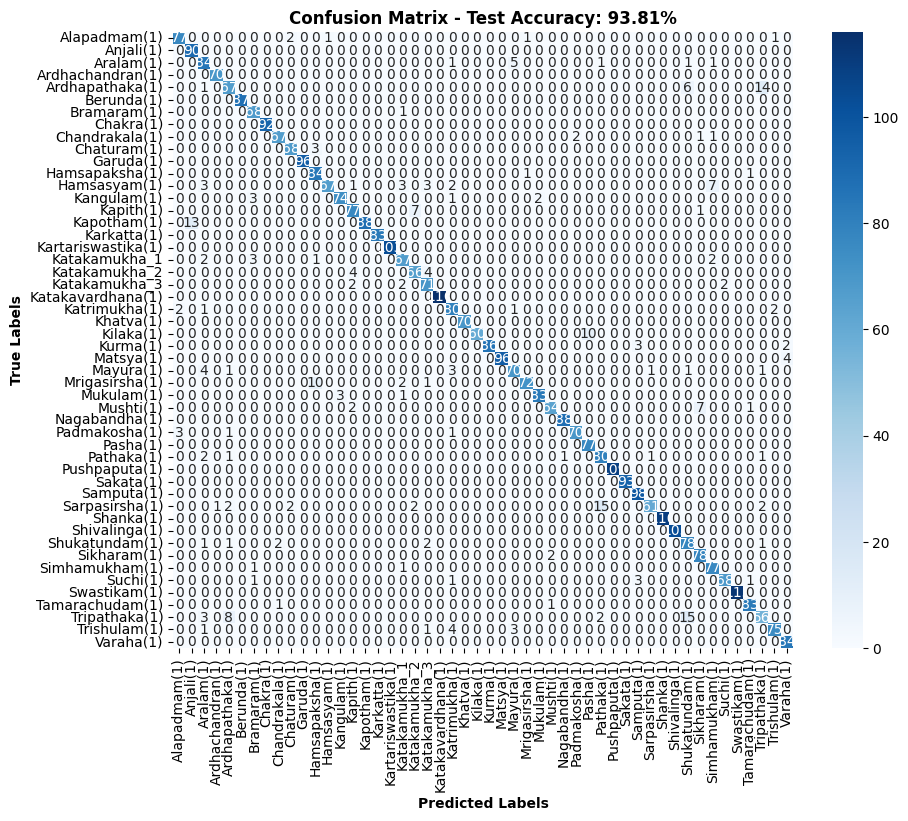

Current best validation accuracy: 0.00%.


In [14]:
# =============================================================================
# 9. FINAL EVALUATION
# =============================================================================
print("\n=== FINAL EVALUATION ON TEST SET ===")
model.load_state_dict(torch.load('best_head_model.pth'))
test_dataset = MelSpectrogramDataset(config['base_dir'], 'test', val_transform)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=config['num_workers'], pin_memory=config['pin_memory'])
test_loss, test_acc, test_preds, test_labels = validate_epoch(model, test_loader, criterion, device)
print(f"\nFinal Test Accuracy: {test_acc:.4f} ({test_acc:.2%})")
print(f"Final Test Loss: {test_loss:.4f}")
print("\nTest Set Classification Report:")
print(classification_report(test_labels, test_preds, target_names=test_dataset.classes, digits=4))

cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted Labels', fontweight='bold')
plt.ylabel('True Labels', fontweight='bold')
plt.title(f'Confusion Matrix - Test Accuracy: {test_acc:.2%}', fontweight='bold')
plt.show()

if best_val_acc >= 0.90:
    print("🚀 CONGRATULATIONS! 90%+ VALIDATION ACCURACY ACHIEVED! 🚀")
else:
    print(f"Current best validation accuracy: {best_val_acc:.2%}.")


=== FINAL EVALUATION ON TEST SET ===
Found 4311 images in test set
Classes: ['Alapadmam(1)', 'Anjali(1)', 'Aralam(1)', 'Ardhachandran(1)', 'Ardhapathaka(1)', 'Berunda(1)', 'Bramaram(1)', 'Chakra(1)', 'Chandrakala(1)', 'Chaturam(1)', 'Garuda(1)', 'Hamsapaksha(1)', 'Hamsasyam(1)', 'Kangulam(1)', 'Kapith(1)', 'Kapotham(1)', 'Karkatta(1)', 'Kartariswastika(1)', 'Katakamukha_1', 'Katakamukha_2', 'Katakamukha_3', 'Katakavardhana(1)', 'Katrimukha(1)', 'Khatva(1)', 'Kilaka(1)', 'Kurma(1)', 'Matsya(1)', 'Mayura(1)', 'Mrigasirsha(1)', 'Mukulam(1)', 'Mushti(1)', 'Nagabandha(1)', 'Padmakosha(1)', 'Pasha(1)', 'Pathaka(1)', 'Pushpaputa(1)', 'Sakata(1)', 'Samputa(1)', 'Sarpasirsha(1)', 'Shanka(1)', 'Shivalinga(1)', 'Shukatundam(1)', 'Sikharam(1)', 'Simhamukham(1)', 'Suchi(1)', 'Swastikam(1)', 'Tamarachudam(1)', 'Tripathaka(1)', 'Trishulam(1)', 'Varaha(1)']


Validation: 100%|██████████| 270/270 [02:31<00:00,  1.78it/s, Loss=0.9050]



Final Test Accuracy: 0.9381 (93.81%)
Final Test Loss: 1.0054

Test Set Classification Report:
                    precision    recall  f1-score   support

      Alapadmam(1)     0.9390    0.9390    0.9390        82
         Anjali(1)     0.8738    1.0000    0.9326        90
         Aralam(1)     0.8235    0.9032    0.8615        93
  Ardhachandran(1)     0.9859    1.0000    0.9929        70
   Ardhapathaka(1)     0.8272    0.7614    0.7929        88
        Berunda(1)     1.0000    1.0000    1.0000        87
       Bramaram(1)     0.8947    0.9855    0.9379        69
         Chakra(1)     1.0000    1.0000    1.0000        92
    Chandrakala(1)     0.9571    0.9437    0.9504        71
       Chaturam(1)     0.9444    0.9577    0.9510        71
         Garuda(1)     1.0000    1.0000    1.0000        96
    Hamsapaksha(1)     0.8571    0.9767    0.9130        86
      Hamsasyam(1)     0.9853    0.7791    0.8701        86
       Kangulam(1)     0.9610    0.9250    0.9427        80
    

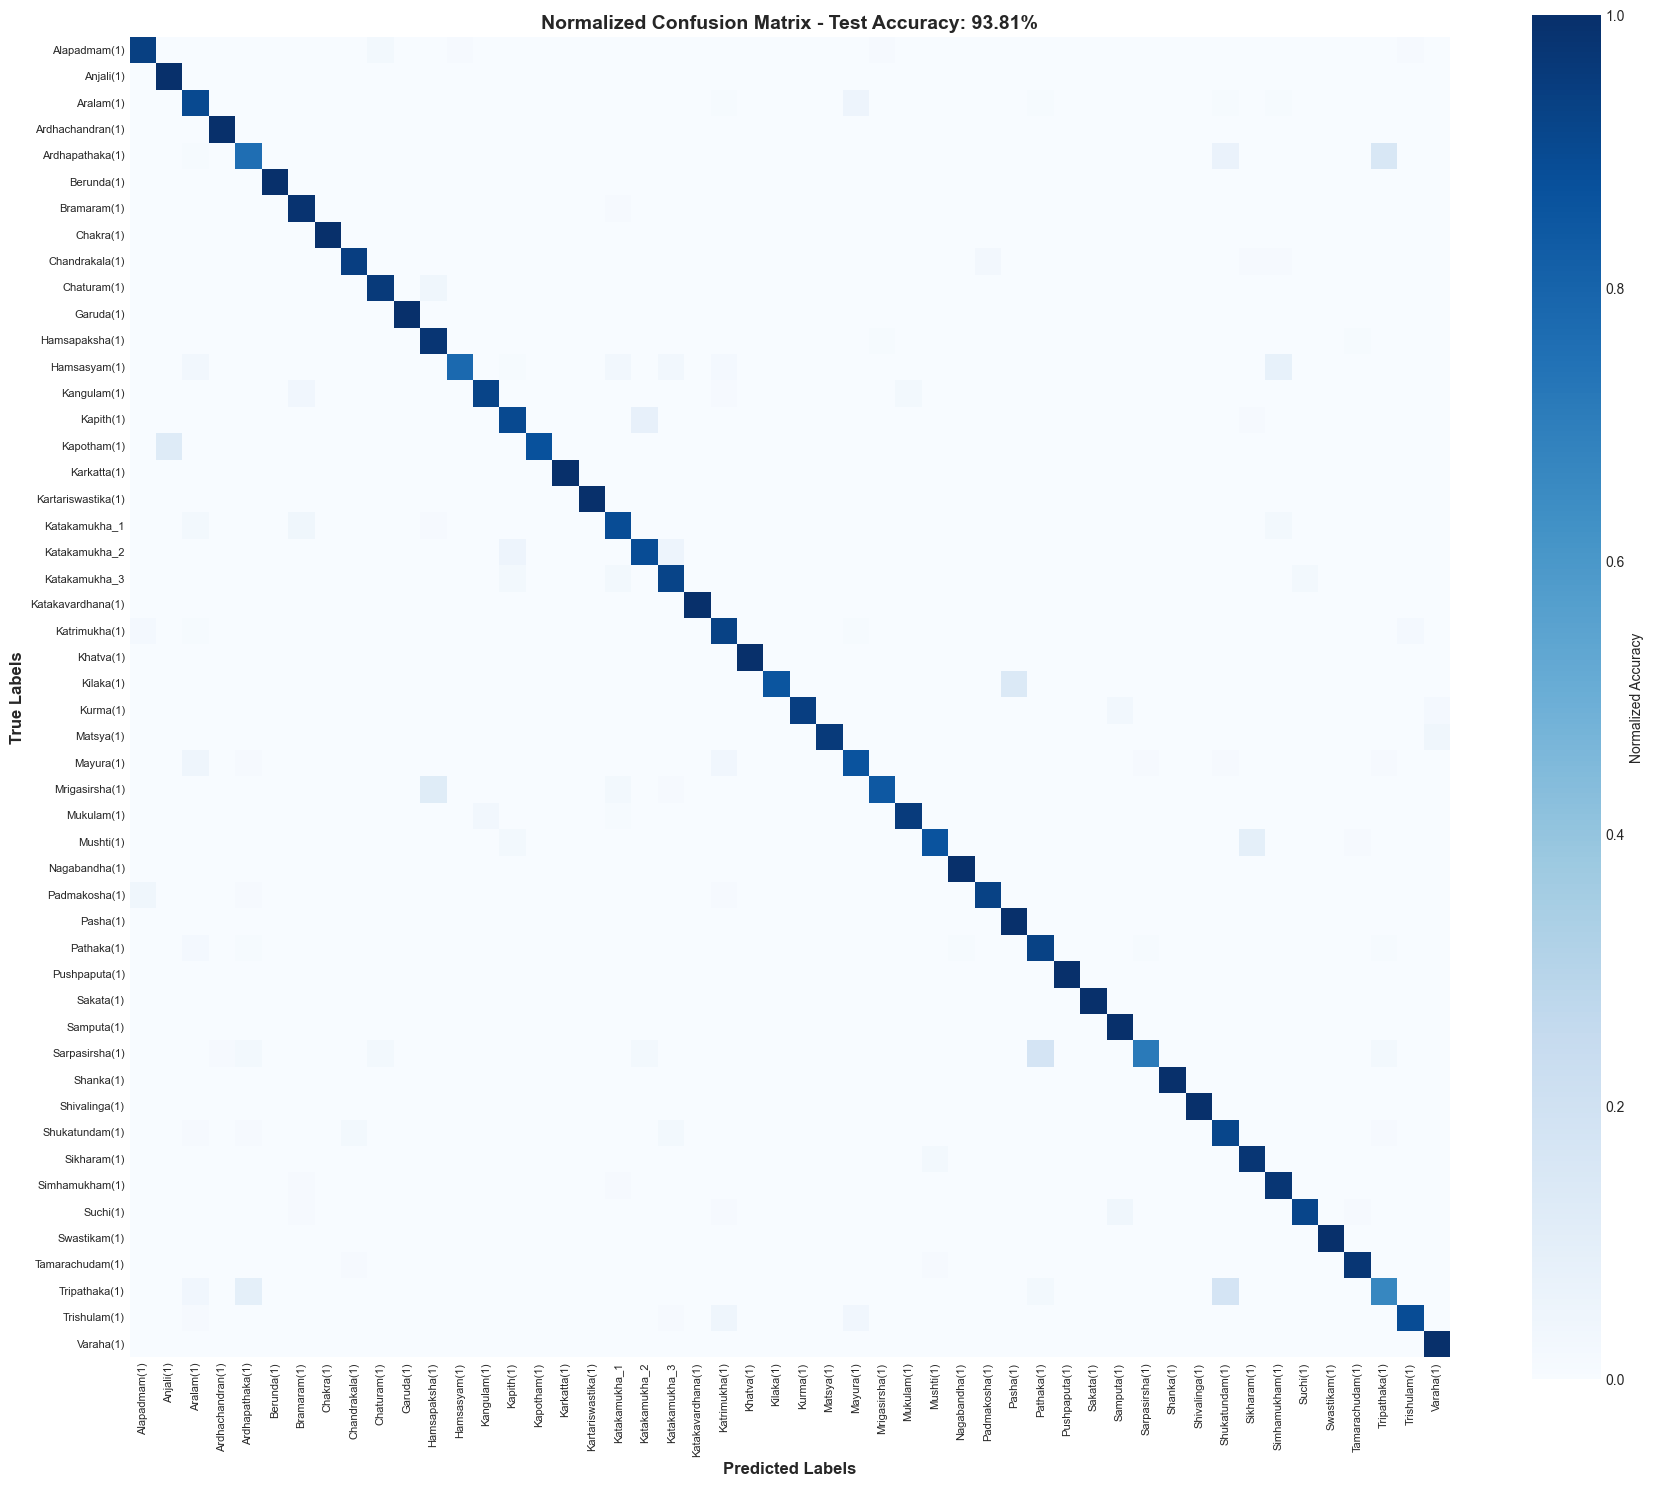

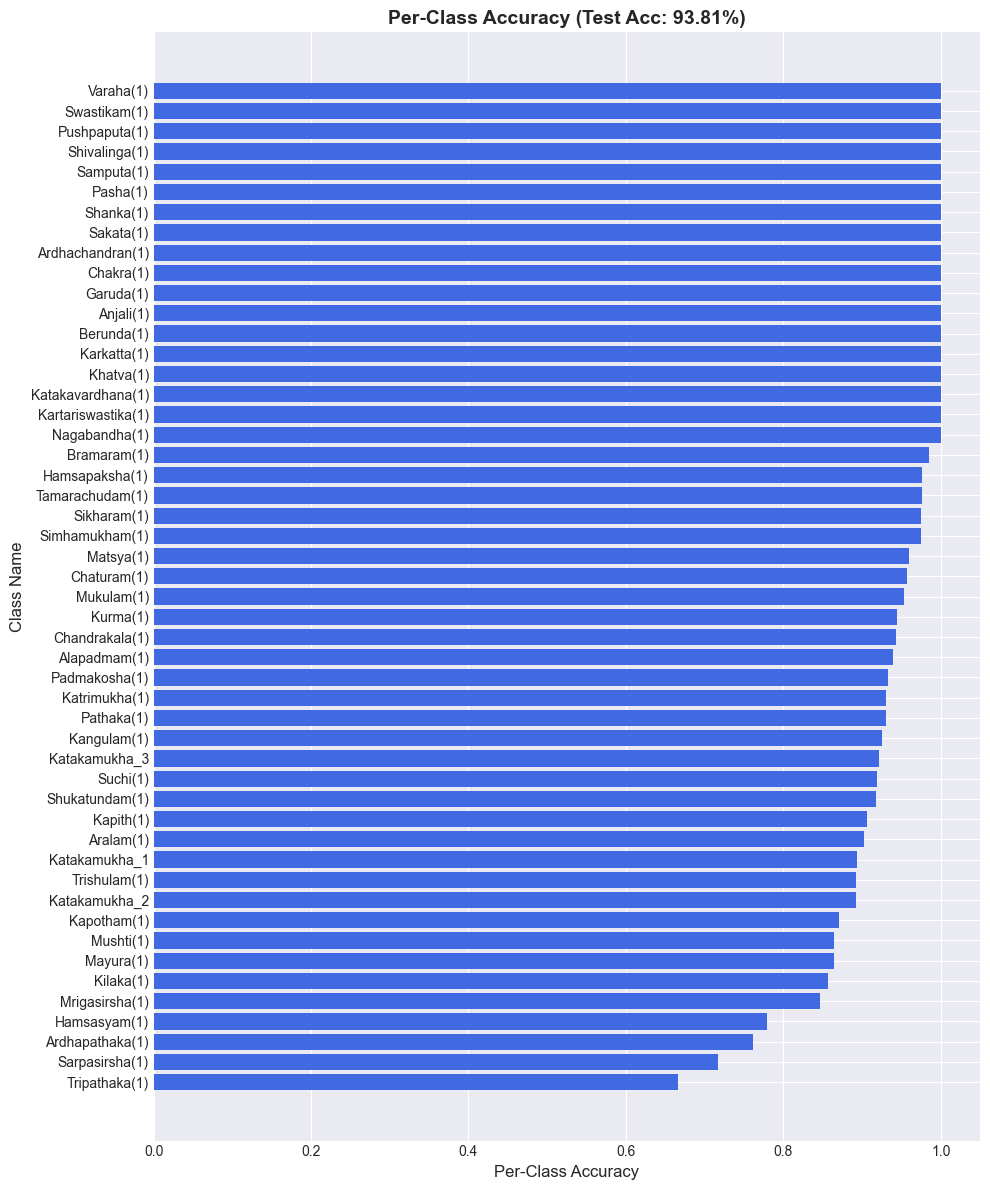

🚀 CONGRATULATIONS! 90%+ TEST ACCURACY ACHIEVED! 🚀


In [21]:
# =============================================================================
# 9. FINAL EVALUATION (Enhanced for Many Classes)
# =============================================================================
print("\n=== FINAL EVALUATION ON TEST SET ===")
model.load_state_dict(torch.load('best_head_model.pth', map_location=device))

test_dataset = MelSpectrogramDataset(config['base_dir'], 'test', val_transform)
test_loader = DataLoader(
    test_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=config['num_workers'],
    pin_memory=config['pin_memory']
)

criterion = nn.CrossEntropyLoss(label_smoothing=config['label_smoothing'])
test_loss, test_acc, test_preds, test_labels = validate_epoch(model, test_loader, criterion, device)

print(f"\nFinal Test Accuracy: {test_acc:.4f} ({test_acc:.2%})")
print(f"Final Test Loss: {test_loss:.4f}")
print("\nTest Set Classification Report:")
print(classification_report(test_labels, test_preds, target_names=test_dataset.classes, digits=4))

# --- Confusion Matrix ---
cm = confusion_matrix(test_labels, test_preds)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm[np.isnan(cm_norm)] = 0  # handle any NaNs for empty classes

fig, ax = plt.subplots(figsize=(18, 15))
sns.heatmap(
    cm_norm,
    cmap='Blues',
    xticklabels=test_dataset.classes,
    yticklabels=test_dataset.classes,
    cbar_kws={'label': 'Normalized Accuracy'},
    square=True,
    ax=ax
)

plt.xlabel('Predicted Labels', fontsize=12, fontweight='bold')
plt.ylabel('True Labels', fontsize=12, fontweight='bold')
plt.title(f'Normalized Confusion Matrix - Test Accuracy: {test_acc:.2%}', fontsize=14, fontweight='bold')

# Reduce tick font size and rotate for readability
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)

# Tight layout for full visibility
plt.tight_layout()
plt.show()

# --- Per-Class Accuracy Bar Chart ---
class_acc = cm.diagonal() / cm.sum(axis=1)
sorted_idx = np.argsort(class_acc)

plt.figure(figsize=(10, 12))
plt.barh(np.array(test_dataset.classes)[sorted_idx], class_acc[sorted_idx], color='royalblue')
plt.xlabel("Per-Class Accuracy", fontsize=12)
plt.ylabel("Class Name", fontsize=12)
plt.title(f"Per-Class Accuracy (Test Acc: {test_acc:.2%})", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# --- Final Summary ---
if test_acc >= 0.90:
    print("🚀 CONGRATULATIONS! 90%+ TEST ACCURACY ACHIEVED! 🚀")
else:
    print(f"Best test accuracy: {test_acc:.2%}. Keep tuning for improvement!")
